# NHL Goals From 2018 To 2024

In this project we are going to analyze how goal scoring patterns in the NHL have evolved during the seasons from 2018 to 2024. We will explore which teams are scoring the most goals, both overall and at home or away games. Additionally, we'll analyze the average goals per game, investigate the correlation between goals and team rankings, and examine whether the number of shots taken has an impact on the number of goals scored. To get started, we have to modify our data. All of the data is from [Hockey Reference.](https://www.hockey-reference.com)

## Modifying and combining data

The first section of this project will be modifying data. Let's first read in the data, so we can add columns to it and combine different seasons into one dataframe.

In [671]:
import pandas as pd
scores_18 = pd.read_csv('scores18_19.csv')
scores_19 = pd.read_csv('scores19_20.csv')
scores_20 = pd.read_csv('scores20_21.csv')
scores_21 = pd.read_csv('scores21_22.csv')
scores_22 = pd.read_csv('scores22_23.csv')
scores_23 = pd.read_csv('scores23_24.csv')

#printing first 3 rows of the 18-19 season
scores_18.head(3)

,Date,Visitor,G,Home,G.1,Unnamed: 5,Att.,LOG,Notes
0,2018-10-03,Anaheim Ducks,5,San Jose Sharks,2,NaN,17562,2:25,NaN
1,2018-10-03,Montreal Canadiens,2,Toronto Maple Leafs,3,OT,19589,2:37,NaN
2,2018-10-03,Calgary Flames,2,Vancouver Canucks,5,NaN,18870,2:31,NaN


In [672]:
#Adding columns
scores_18['Season'] = '2018-2019'
scores_19['Season'] = '2019-2020'
scores_20['Season'] = '2020-2021'
scores_21['Season'] = '2021-2022'
scores_22['Season'] = '2022-2023'
scores_23['Season'] = '2023-2024'

#printing first 3 rows
scores_18.head(3)

,Date,Visitor,G,Home,G.1,Unnamed: 5,Att.,LOG,Notes,Season
0,2018-10-03,Anaheim Ducks,5,San Jose Sharks,2,NaN,17562,2:25,NaN,2018-2019
1,2018-10-03,Montreal Canadiens,2,Toronto Maple Leafs,3,OT,19589,2:37,NaN,2018-2019
2,2018-10-03,Calgary Flames,2,Vancouver Canucks,5,NaN,18870,2:31,NaN,2018-2019


In [673]:
#Combining all the scores to one dataframe

scores_all = pd.concat([scores_18, scores_19, scores_20, scores_21, scores_22, scores_23], ignore_index = True)


2023-2024 is not finished yet, meaning that over half of the games have not been played yet. Let's delete all of those that contain null values for goals.

In [674]:
scores_all.dropna(subset=['G'], inplace=True)
#printing last 3 rows
scores_all.tail(3)

,Date,Visitor,G,Home,G.1,Unnamed: 5,Att.,LOG,Notes,Season
6476,2024-01-09,Los Angeles Kings,2.0,Tampa Bay Lightning,3.0,OT,19092.0,2:30,NaN,2023-2024
6477,2024-01-09,San Jose Sharks,1.0,Toronto Maple Leafs,7.0,NaN,18364.0,2:28,NaN,2023-2024
6478,2024-01-09,Columbus Blue Jackets,0.0,Winnipeg Jets,5.0,NaN,12512.0,2:23,NaN,2023-2024


Let's change the name of column `Unnamed: 5` to `OT`, meaning overtime. If the value in that column is "OT", meaning that the game went overtime, we assing it a value of 1. If the value is null, we will assign it a value of 0. Let's add new `Total_reg` and `Total` columns, which are the sum of `G` and `G.1`. `Total_reg` is the amount of goals scored in the regulation time, and `Total` is the total amount of goals scored including overtime. Last modification is to delete `LOG`and `Notes` columns. These contain information about the length of the game and other information about stadiums etc. While these might provide valuable information for single games, overall they don't matter for our purposes of analyzing the amount of goals scored.

In [675]:
#Renaming OT and assigning values 1 or 0
scores_all.rename(columns={'Unnamed: 5': 'OT'}, inplace=True)
scores_all['OT'] = scores_all['OT'].apply(lambda x: 1 if x == 'OT' else 0)

#Total goals are home goals + visitor goals
scores_all['Total'] = scores_all['G'] + scores_all['G.1']

#Total goals in regulation time are total goals - 1, if OT == 1
scores_all.loc[scores_all['OT'] == 1, 'Total_reg'] = scores_all['Total'] - 1
scores_all.loc[scores_all['OT'] == 0, 'Total_reg'] = scores_all['Total']

#Deleting LOG and Notes columns
scores_all = scores_all.drop(columns = ['LOG', 'Notes'])

scores_all.tail(3)

,Date,Visitor,G,Home,G.1,OT,Att.,Season,Total,Total_reg
6476,2024-01-09,Los Angeles Kings,2.0,Tampa Bay Lightning,3.0,1,19092.0,2023-2024,5.0,4.0
6477,2024-01-09,San Jose Sharks,1.0,Toronto Maple Leafs,7.0,0,18364.0,2023-2024,8.0,8.0
6478,2024-01-09,Columbus Blue Jackets,0.0,Winnipeg Jets,5.0,0,12512.0,2023-2024,5.0,5.0


We also have data of shots for all of the seasons, which I was also gathered from [Hockey Reference](https://www.hockey-reference.com) and combined together in Excel, so it doesn't need further modification, besides deleting the "*" from teams that entered playoffs. Here are the first 5 rows of it. 

In [676]:
shot_data = pd.read_csv('shotdata18_24.csv')
for index,row in shot_data.iterrows():
    team = row['Team']
    team = team.replace("*","")
    shot_data.at[index, 'Team'] = team
shot_data.head(5)

,SeasonStart,Rk,Team,S,S%,SA,SV%,SO
0,2018,1,Tampa Bay Lightning,2620,12.2,2633,0.916,6
1,2018,2,Boston Bruins,2680,9.6,2416,0.912,9
2,2018,3,Calgary Flames,2656,10.9,2302,0.903,3
3,2018,4,Washington Capitals,2492,11.0,2584,0.904,4
4,2018,5,New York Islanders,2360,9.4,2534,0.925,11


Now we are ready to start analyzing our data.

## Goals Per Season

We will begin our project by looking at how the amount of goals scored has changed during the years. This is the reason we created a new column with each season's year, so we can group by the year to easily find out the amount of goals scored each year.

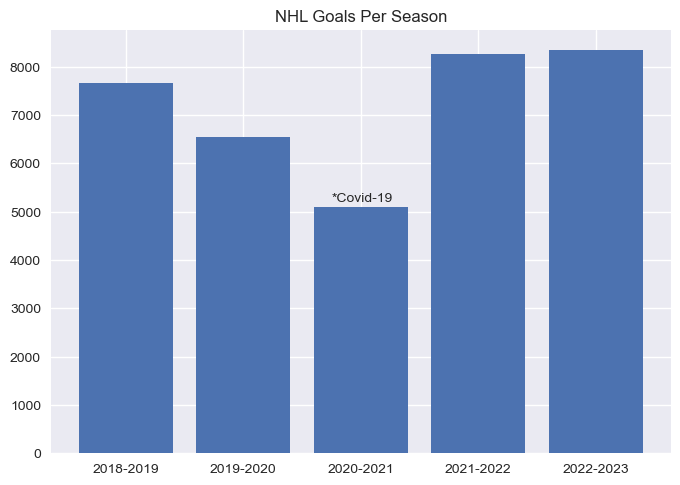

In [677]:
import matplotlib.pyplot as plt

scores_per_season = scores_all.groupby(['Season']).sum()
#Filtering 2024 out of data, because the season is only half finished
filtered_scores_per_season = scores_per_season[scores_per_season.index != '2023-2024']
season = filtered_scores_per_season.index
total_goals = filtered_scores_per_season['Total']

#Plotting barchart for total goals
plt.style.use('seaborn-v0_8')
plt.bar(season, total_goals)
plt.title('NHL Goals Per Season')
plt.text(1.75, 5200, '*Covid-19')
plt.show()

From the bar chart above we can see that the last two seasons have more goals scored than previous seasons. Season 2020-2021 is an exception, because the regular season was reduced to 56 games due to COVID-19. Seasons 2021-2022 and 2022-2023 have more goals, which might be because Seattle Kraken joined the NHL in 2021, making the total games played higher. Let's now take a closer look at the average goals per game.

In [696]:
#Games played per season, includes 2024
for season in scores_per_season.index:
    #Includes OT
    games_played = scores_all[scores_all['Season'] == season].shape[0] #counts amount of rows
    amount_of_goals = scores_per_season.loc[season, 'Total']
    avg_per_game = amount_of_goals/games_played
    #Regular time
    amount_of_goals_reg = scores_per_season.loc[season, 'Total_reg']
    avg_per_game_reg = amount_of_goals_reg/games_played
    #Adding new columns to data, we will use them later
    scores_per_season.loc[season, 'Avg'] = avg_per_game
    scores_per_season.loc[season, 'Avg_reg'] = avg_per_game_reg
print(scores_per_season['Avg'])
print(scores_per_season['Avg_reg'])

Season
2018-2019    6.029898
2019-2020    6.038817
2020-2021    5.870968
2021-2022    6.289634
2022-2023    6.358994
2023-2024    6.296530
Name: Avg, dtype: float64
Season
2018-2019    5.885130
2019-2020    5.887246
2020-2021    5.721198
2021-2022    6.147866
2022-2023    6.201220
2023-2024    6.159306
Name: Avg_reg, dtype: float64


We can see that the lowest average goals were during 2020-2021 (Covid-19 season). After that the average goals have increased to around 6.3 goals per game. If we exclude overtime, the average goals are a little bit lower. Before plotting the average goals, let's also count the median goals.

In [679]:
#Games played per season, includes 2024
for season in scores_per_season.index:
    filtered_scores = scores_all[scores_all['Season'] == season]
    median_goals = filtered_scores['Total'].median()
    median_goals_reg = filtered_scores['Total_reg']
    #Adding new column
    scores_per_season.loc[season, 'Median'] = median_goals
    scores_per_season.loc[season, 'Median_reg'] = median_goals
print(scores_per_season['Median'])
print(scores_per_season['Median_reg'])


Season
2018-2019    6.0
2019-2020    6.0
2020-2021    6.0
2021-2022    6.0
2022-2023    6.0
2023-2024    6.0
Name: Median, dtype: float64
Season
2018-2019    6.0
2019-2020    6.0
2020-2021    6.0
2021-2022    6.0
2022-2023    6.0
2023-2024    6.0
Name: Median_reg, dtype: float64


The median for all of the seasons is 6.0, and over time doesn't affect median goals. For seasons 2018-2021 medians are a little bit higher than the average goals, and for seasons 2021-2024 the medians are a little bit lower than the average goals.

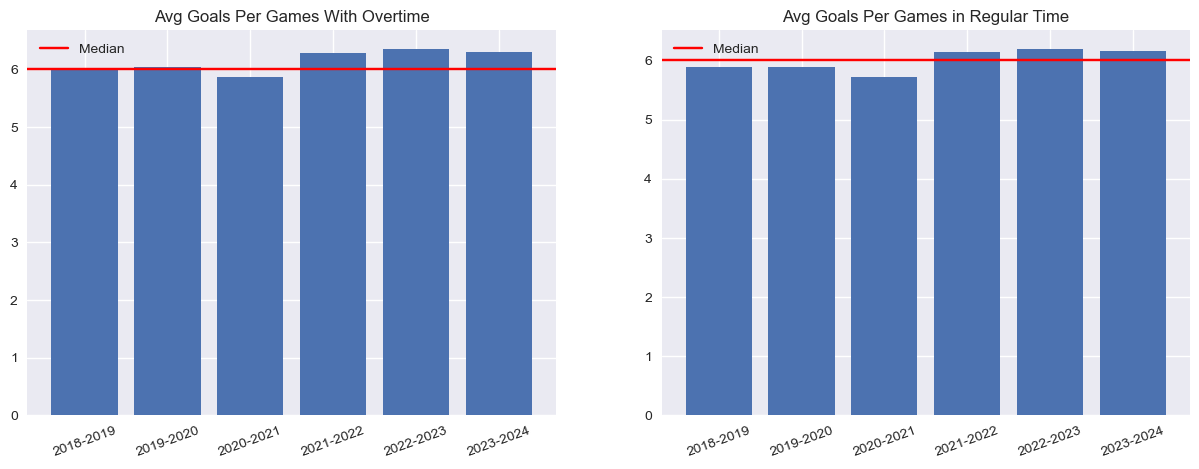

In [699]:
#Plotting previous observations
season = scores_per_season.index
avg_goals = scores_per_season['Avg']
avg_goals_reg = scores_per_season['Avg_reg']

#Including overtime
fig, axs = plt.subplots(1,2, figsize=(15,5))
axs[0].bar(season,avg_goals)
axs[0].set_xticks(season)
axs[0].set_xticklabels(season, rotation=20)
axs[0].set_title('Avg Goals Per Games With Overtime')
axs[0].axhline(y=6, color='r', label='Median')
axs[0].legend()

#Regular time
axs[1].bar(season,avg_goals_reg)
axs[1].set_xticks(season)
axs[1].set_xticklabels(season, rotation=20)
axs[1].set_title('Avg Goals Per Games in Regular Time')
axs[1].axhline(y=6, color='r', label='Median')
axs[1].legend()

## Goals Per Team

Now we are going to dive into different teams, and check how many goals each team has scored during seasons 2018-2024. We are also going to check which teams have been best home teams and away teams.

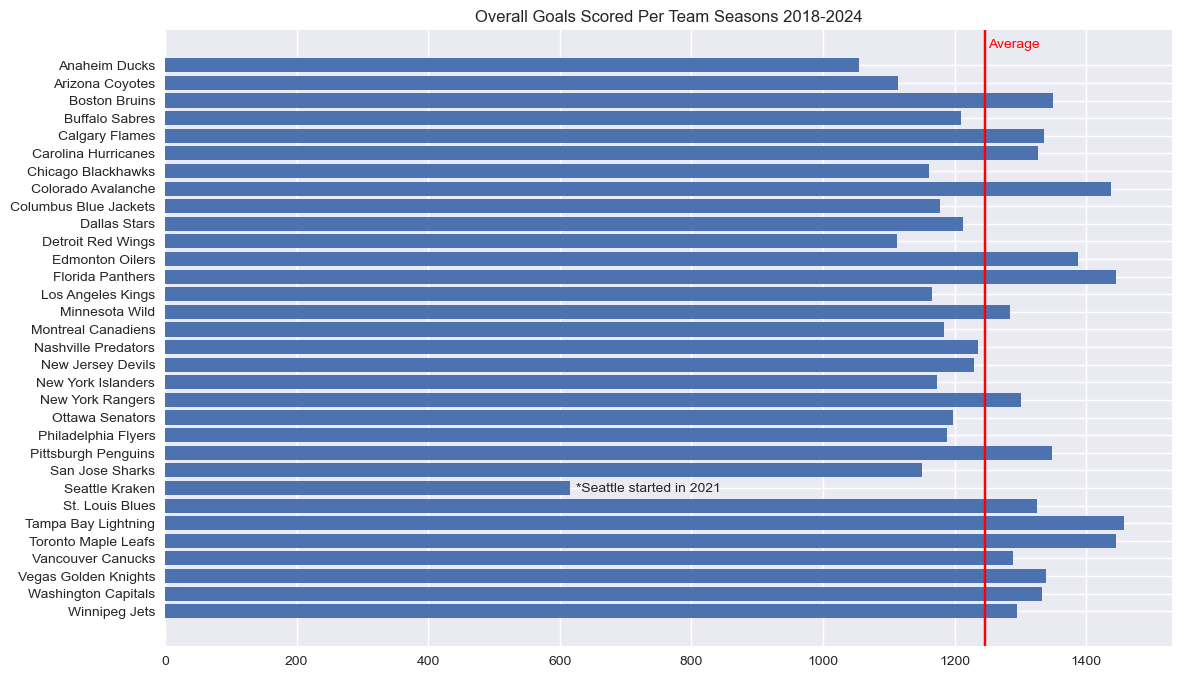

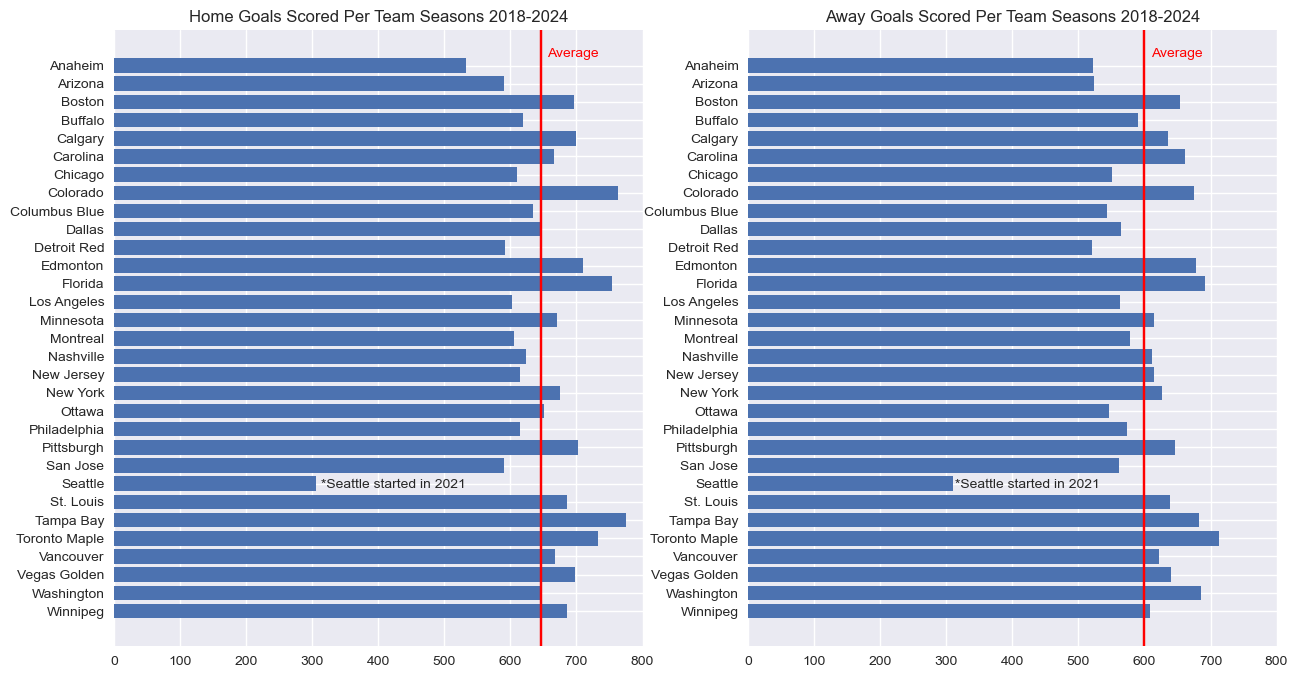

In [718]:
#All of the seasons
home_games = {}
away_games = {}
overall_games = {}

for index,row in scores_all.iterrows():
    away_team = row['Visitor']
    away_goals = row['G']
    home_team = row['Home']
    home_goals = row['G.1']
    
    #Adding Visitor team goals to away and overall goals
    if away_team in away_games:
        away_games[away_team] += away_goals
    else:
        away_games[away_team] = away_goals
    
    if away_team in overall_games:
        overall_games[away_team] += away_goals
    else:
        overall_games[away_team] = away_goals
    #Adding Home team goals to home and overall goals
    if home_team in home_games:
        home_games[home_team] += home_goals
    else:
        home_games[home_team] = home_goals
        
    if home_team in overall_games:
        overall_games[home_team] += home_goals
    else:
        overall_games[home_team] = home_goals

#To plot these, we need to make them lists
h_teams = list(home_games.keys())
h_goals = list(home_games.values())
a_teams = list(away_games.keys())
a_goals = list(away_games.values())
teams = list(overall_games.keys())
goals = list(overall_games.values())

#overall goals sorted
sorted_teams, sorted_goals = zip(*sorted(zip(teams, goals), reverse=True))
plt.figure(figsize=(13,8))
plt.barh(sorted_teams, sorted_goals)
plt.text(625,6.75,"*Seattle started in 2021")
plt.title("Overall Goals Scored Per Team Seasons 2018-2024")
plt.text(1250, 32, "Average", color='r')
plt.axvline(x=sum(goals)/len(goals), color='r')
plt.show()

#Shortening team names so these 2 charts fit
short_h_teams = [" ".join(team.split()[:-1]) for team in h_teams]
short_a_teams = [" ".join(team.split()[:-1]) for team in a_teams]

#home goals sorted
sorted_h_teams, sorted_h_goals = zip(*sorted(zip(short_h_teams, h_goals), reverse=True))
fig, axs = plt.subplots(1,2, figsize = (15,8))
axs[0].barh(sorted_h_teams, sorted_h_goals )
axs[0].text(312.5,6.75, "*Seattle started in 2021")
axs[0].set_title("Home Goals Scored Per Team Seasons 2018-2024")
axs[0].axvline(x=sum(h_goals)/len(h_goals),color='r')
axs[0].set_xlim(0,800)
axs[0].text(655, 30.5, "Average", color='r')

#away goals sorted
sorted_a_teams, sorted_a_goals = zip(*sorted(zip(short_a_teams, a_goals), reverse=True))
axs[1].barh(sorted_a_teams, sorted_a_goals)
axs[1].text(312.5,6.75, "*Seattle started in 2021")
axs[1].set_title("Away Goals Scored Per Team Seasons 2018-2024")
axs[1].axvline(x=sum(a_goals)/len(a_goals),color='r')
axs[1].set_xlim(0,800)
axs[1].text(610, 30.5, "Average", color='r')
plt.show()


From the charts above we can see that Seattle has the fewest goals scored, which can be explained by the fact that they joined the NHL in 2021. We can also see that teams score more at home games (on average 646.9 goals per team) than on away games (599.4 goals per team). Overall, team's have scored 1246.2 goals on average in 5.5 seasons.

## Average Goals Per Game By Team

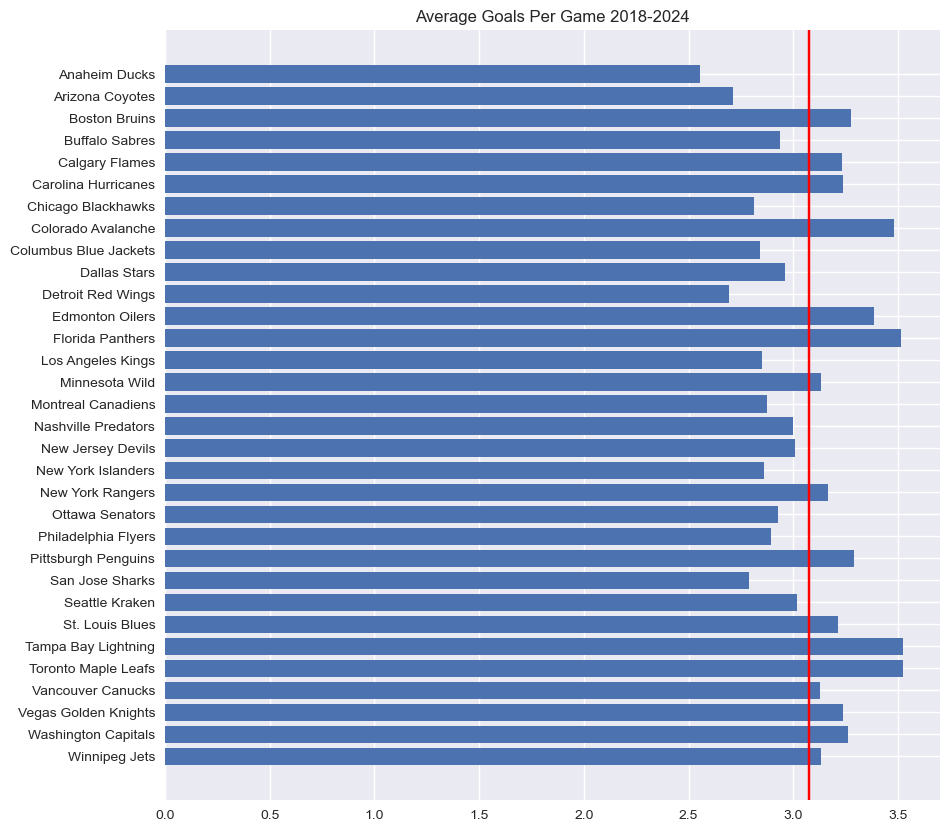

In [726]:
#Games played per team
h_teams_games_played = {}
a_teams_games_played = {}
teams_games_played = {}
for index,row in scores_all.iterrows():
    visitor = row['Visitor']
    home = row['Home']
    #Overall games
    if visitor in teams_games_played:
        teams_games_played[visitor] += 1
    else:
        teams_games_played[visitor] = 1
        
    if home in teams_games_played:
        teams_games_played[home] += 1
    else:
        teams_games_played[home] = 1
    #Away games
    if visitor in a_teams_games_played:
        a_teams_games_played[visitor] += 1
    else:
        a_teams_games_played[visitor] = 1

    #Home games    
    if home in h_teams_games_played:
        h_teams_games_played[home] += 1
    else:
        h_teams_games_played[home] = 1

#Avg goals = goals scored / games played
avg_h_goals = {}
avg_a_goals = {}
avg_goals = {}

for team in teams:
    #Getting values from dictionaries using keys
    h_goals_scored = home_games[team]
    a_goals_scored = away_games[team]
    goals_scored = overall_games[team]
    h_games_played = h_teams_games_played[team]
    a_games_played = a_teams_games_played[team]
    games_played = teams_games_played[team]
    #Assigning values to new dictionaries
    avg_h_goals[team] = h_goals_scored/h_games_played
    avg_a_goals[team] = a_goals_scored/a_games_played
    avg_goals[team] = goals_scored/games_played


#plotting overall goals
teams = list(avg_goals.keys())
goals = list(avg_goals.values())
sorted_teams, sorted_goals = zip(*sorted(zip(teams, goals), reverse=True))

plt.figure(figsize=(10,10))
plt.barh(sorted_teams,sorted_goals)
plt.title("Average Goals Per Game 2018-2024")
plt.axvline(sum(goals)/len(goals), color='r')
plt.show()

The chart above shows average goals per game for teams between seasons 2018-2023. We can see that especially Anaheim Ducks, Detroit Red Wings, Arizona Coyotes and San Jose Sharks have had trouble scoring goals. Let's now take a closer look at top 5 goal scorers.

## Top 5 Goal Scorers

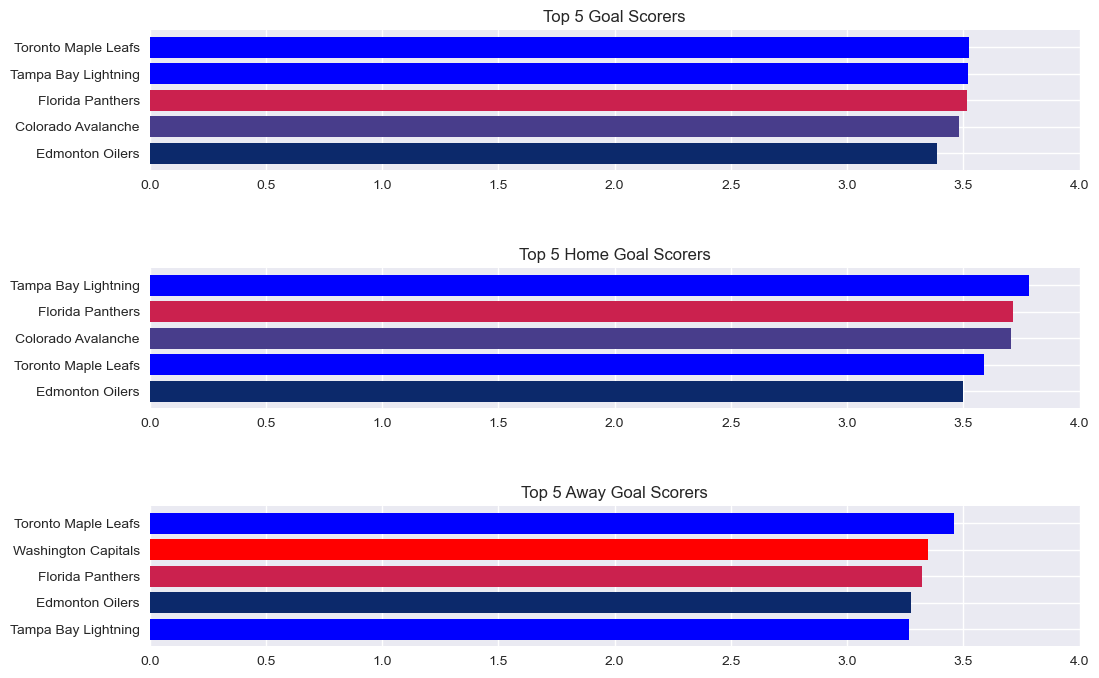

In [683]:
#Sorting dictionaries by avg goals
#Overall
top_5_dict = dict(sorted(avg_goals.items(), key=lambda item: item[1], reverse=True)[:5])
top_5_teams = list(top_5_dict.keys())
top_5_goals = list(top_5_dict.values())
#Home
top_5_hdict = dict(sorted(avg_h_goals.items(), key=lambda item: item[1], reverse=True)[:5])
top_5_hteams = list(top_5_hdict.keys())
top_5_hgoals = list(top_5_hdict.values())
#Away
top_5_adict = dict(sorted(avg_a_goals.items(), key=lambda item: item[1], reverse=True)[:5])
top_5_ateams = list(top_5_adict.keys())
top_5_agoals = list(top_5_adict.values())


#Plotting
fig, axs = plt.subplots(3,1, figsize=(12,8))
plt.subplots_adjust(hspace=0.7)

#Overall
top_5_teams.reverse()
top_5_goals.reverse()
colors = ['#0c296b','#483d8b', "#cb214e", 'b', 'b']
axs[0].barh(top_5_teams, top_5_goals, color=colors)
axs[0].set_xlim(0,4)
axs[0].set_title("Top 5 Goal Scorers")

#Home
top_5_hteams.reverse()
top_5_hgoals.reverse()
colors = ['#0c296b','b', "#483d8b", '#cb214e', 'b']
axs[1].barh(top_5_hteams, top_5_hgoals, color=colors)
axs[1].set_xlim(0,4)
axs[1].set_title("Top 5 Home Goal Scorers")

#Away
top_5_ateams.reverse()
top_5_agoals.reverse()
colors = ['b','#0c296b', "#cb214e", 'r', 'b']
axs[2].barh(top_5_ateams, top_5_agoals, color=colors)
axs[2].set_xlim(0,4)
axs[2].set_title("Top 5 Away Goal Scorers")
plt.show()

There are six teams when looking at data for top 5 goal scorers for home goals, away goals and overall goals. Home goals and overall goals top 5 is Colorado Avalance, Edmonton Oilers, Florida Panthers, Tampa Bay Lightning and Toronto Maple Leags. When looking at top 5 away goal scorers, Washington Capitals replaces Colorado Avalanche.

## Correlation Between Shots Fired And Goals Scored

Next we are going to take a look at how the amount of shots correlates with the amount of goals scored. For this we use our second dataset, `shot_data`. Let's print a few rows to see what the data looks like.

In [684]:
print(shot_data.head(3))
print(shot_data.tail(3))

   SeasonStart  Rk                 Team     S    S%    SA    SV%  SO
0         2018   1  Tampa Bay Lightning  2620  12.2  2633  0.916   6
1         2018   2        Boston Bruins  2680   9.6  2416  0.912   9
2         2018   3       Calgary Flames  2656  10.9  2302  0.903   3
     SeasonStart  Rk                Team     S    S%    SA    SV%  SO
186         2023  30     Ottawa Senators  1165  10.1  1137  0.885   1
187         2023  31  Chicago Blackhawks  1072   8.9  1339  0.886   1
188         2023  32     San Jose Sharks  1036   7.8  1457  0.885   0


For our shot data we have only full seasons from 2018 to 2023. Now we are going to look at wheter shooting more correlates with the amount of goals scored, and which teams shoot the most.

In [685]:
#shots fired per team
shots_fired = {}
for index, row in shot_data.iterrows():
    team = row['Team']
    shots = row['S']
    if team in shots_fired:
        shots_fired[team] += shots
    else:
        shots_fired[team] = shots
shots_fired = dict(sorted(shots_fired.items()))
#now we have 2 dicts: overall_games contains goals per team in overall games, shots_fired contains shots per team

#Turns dicts to dataframes
shots_fired_df = pd.DataFrame(list(shots_fired.items()), columns =['Team', 'Shots'])
goals_scored_df = pd.DataFrame(list(overall_games.items()), columns = ['Team', 'Goals'])

shots_goals_data = pd.merge(shots_fired_df, goals_scored_df, on='Team')

print(shots_goals_data)

                     Team  Shots   Goals
0           Anaheim Ducks  11776  1055.0
1         Arizona Coyotes  11576  1114.0
2           Boston Bruins  13673  1350.0
3          Buffalo Sabres  12705  1209.0
4          Calgary Flames  13721  1335.0
5     Carolina Hurricanes  13856  1327.0
6      Chicago Blackhawks  12175  1161.0
7      Colorado Avalanche  13782  1438.0
8   Columbus Blue Jackets  12576  1177.0
9            Dallas Stars  12617  1213.0
10      Detroit Red Wings  11764  1113.0
11        Edmonton Oilers  12963  1388.0
12       Florida Panthers  14348  1445.0
13      Los Angeles Kings  13053  1166.0
14         Minnesota Wild  12602  1284.0
15     Montreal Canadiens  12758  1184.0
16    Nashville Predators  12754  1235.0
17      New Jersey Devils  12797  1230.0
18     New York Islanders  12077  1173.0
19       New York Rangers  12375  1301.0
20        Ottawa Senators  12640  1197.0
21    Philadelphia Flyers  12723  1189.0
22    Pittsburgh Penguins  13590  1348.0
23        San Jo

From above we can see how many shots each team has shot, and how many goals each team has scored. Let's now make a scatterplot for a clearer picture of the relationship between shots fired and goals scored. We will exclude Seattle from our scatter plot, by limiting the x-axis and the y-axis.

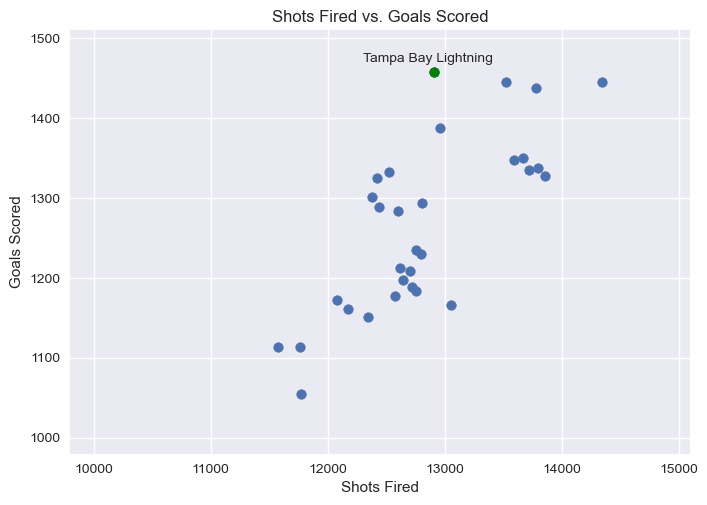

In [686]:
plt.scatter(shots_goals_data['Shots'], shots_goals_data['Goals'])
plt.xlim(9800,15100)
plt.ylim(980,1510)
plt.xlabel('Shots Fired')
plt.ylabel('Goals Scored')
plt.title('Shots Fired vs. Goals Scored')
#highlighting most goals scored
plt.scatter(12910, 1458, color='g')
plt.text(x=12300, y=1470, s='Tampa Bay Lightning')
plt.show()

This scatter plot clearly shows that those teams that have scored fewest goals have also lowest amount of shots fired. While the amount of goals scored increases with the amount of shots fired, it does not directly indicate that more shots equals more goals. For example the team with most goals scored is Tampa Bay Lightning, with less than 13,000 shots fired. We can conclude that other factors also affect goals scored, for example where the shot was fired from.

## How Scoring Goals Affects Ranking in Regular Season

Now we are going to look at how the amount of goals scored affects rankings in regular season. To do this we are going to use each season separately. We can do this easily by adding yearly goals to our `shot_data`, since it contains rankings for each season. Yearly goals are shots fired multiplied by shooting percentage, meaning `S` column and `S%` columns.

In [687]:
#Adding goals for each team for each season
shot_data['Goals'] = shot_data['S'] * shot_data['S%'] / 100
#rounding the result
shot_data['Goals'] = shot_data['Goals'].round(0)
print(shot_data.head(3))

   SeasonStart  Rk                 Team     S    S%    SA    SV%  SO  Goals
0         2018   1  Tampa Bay Lightning  2620  12.2  2633  0.916   6  320.0
1         2018   2        Boston Bruins  2680   9.6  2416  0.912   9  257.0
2         2018   3       Calgary Flames  2656  10.9  2302  0.903   3  290.0


Now that we have the amount of goals for each team and for each season, let's make a scatter plot for all of the seasons.

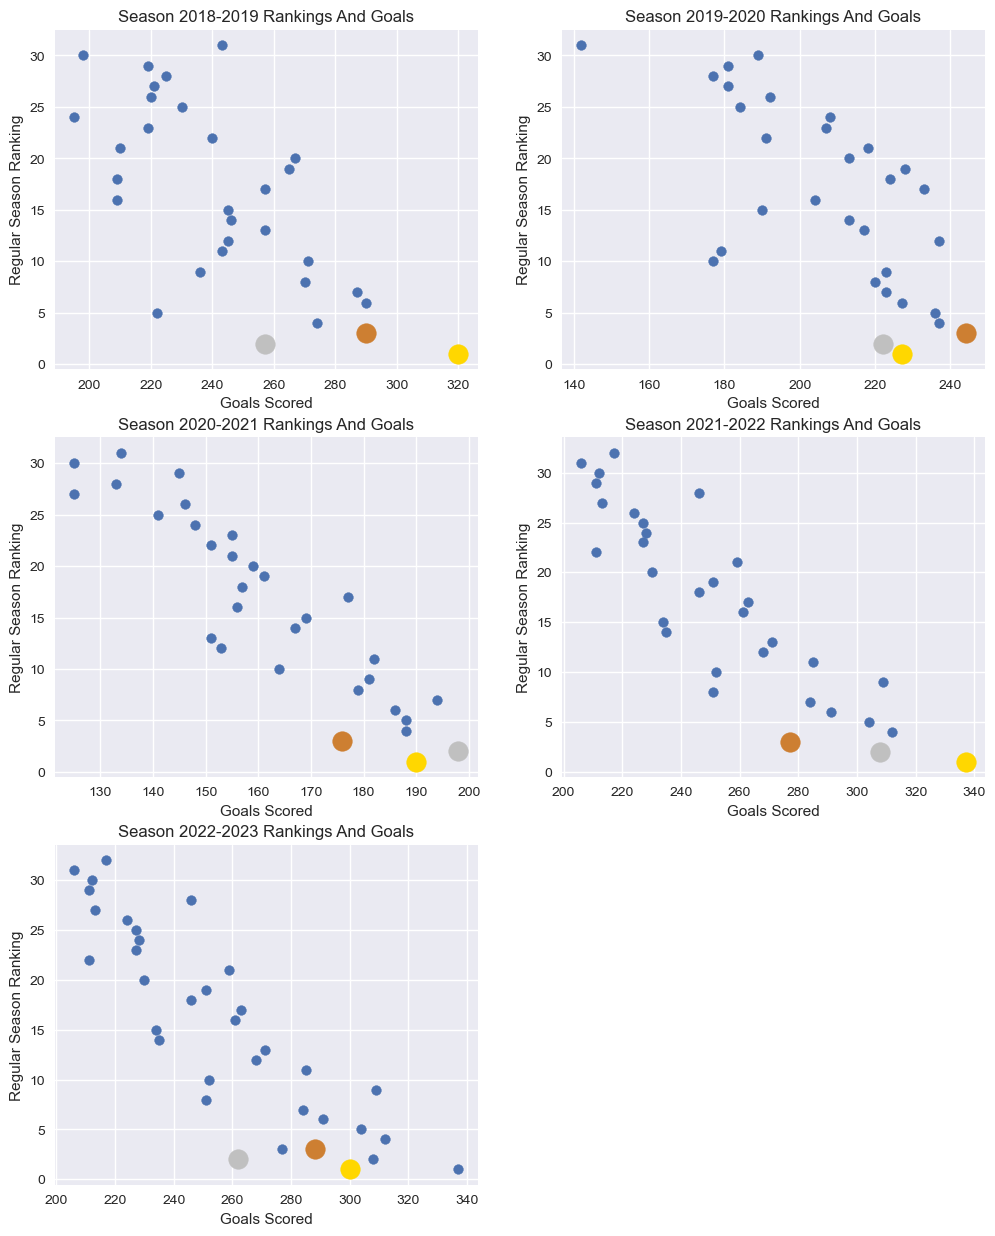

In [688]:
fig, axs = plt.subplots(3,2, figsize=(12,15))
#deleting empty chart
fig.delaxes(axs[2,1])

#2018
data_2018 = shot_data[shot_data['SeasonStart'] == 2018]
axs[0,0].scatter(data_2018['Goals'],data_2018['Rk'])
axs[0,0].scatter(320, 1, s=200,color='gold')
axs[0,0].scatter(257, 2, s=200, color='silver')
axs[0,0].scatter(290, 3, s=200, color='#CD7F32') #bronze
axs[0,0].set_title('Season 2018-2019 Rankings And Goals')
axs[0,0].set_xlabel('Goals Scored')
axs[0,0].set_ylabel('Regular Season Ranking')

#2019
data_2019 = shot_data[shot_data['SeasonStart'] == 2019]
axs[0,1].scatter(data_2019['Goals'],data_2019['Rk'])
axs[0,1].scatter(227, 1, s=200,color='gold')
axs[0,1].scatter(222, 2, s=200, color='silver')
axs[0,1].scatter(244, 3, s=200, color='#CD7F32') #bronze
axs[0,1].set_title('Season 2019-2020 Rankings And Goals')
axs[0,1].set_xlabel('Goals Scored')
axs[0,1].set_ylabel('Regular Season Ranking')

#2020
data_2020 = shot_data[shot_data['SeasonStart'] == 2020]
axs[1,0].scatter(data_2020['Goals'],data_2020['Rk'])
axs[1,0].scatter(190, 1, s=200,color='gold')
axs[1,0].scatter(198, 2, s=200, color='silver')
axs[1,0].scatter(176, 3, s=200, color='#CD7F32') #bronze
axs[1,0].set_title('Season 2020-2021 Rankings And Goals')
axs[1,0].set_xlabel('Goals Scored')
axs[1,0].set_ylabel('Regular Season Ranking')

#2021
data_2021 = shot_data[shot_data['SeasonStart'] == 2021]
axs[1,1].scatter(data_2021['Goals'],data_2021['Rk'])
axs[1,1].scatter(337, 1, s=200,color='gold')
axs[1,1].scatter(308, 2, s=200, color='silver')
axs[1,1].scatter(277, 3, s=200, color='#CD7F32') #bronze
axs[1,1].set_title('Season 2021-2022 Rankings And Goals')
axs[1,1].set_xlabel('Goals Scored')
axs[1,1].set_ylabel('Regular Season Ranking')

#2022
data_2022 = shot_data[shot_data['SeasonStart'] == 2022]
axs[2,0].scatter(data_2021['Goals'],data_2021['Rk'])
axs[2,0].scatter(300, 1, s=200,color='gold')
axs[2,0].scatter(262, 2, s=200, color='silver')
axs[2,0].scatter(288, 3, s=200, color='#CD7F32') #bronze
axs[2,0].set_title('Season 2022-2023 Rankings And Goals')
axs[2,0].set_xlabel('Goals Scored')
axs[2,0].set_ylabel('Regular Season Ranking')
plt.show()




From the scatterplots above we can see that usually the top 3 teams (colored plots) are more on the right side of the chart. This means that higher ranking teams seem to score more goals than lower ranking teams. Let's calculate Pearson's correlation to check how significant the correlation is.

In [689]:
print(f"Season 2018-19 correlation: {data_2018['Rk'].corr(data_2018['Goals'])}")
print(f"Season 2019-20 correlation: {data_2019['Rk'].corr(data_2019['Goals'])}")
print(f"Season 2020-21 correlation: {data_2020['Rk'].corr(data_2020['Goals'])}")
print(f"Season 2021-22 correlation: {data_2021['Rk'].corr(data_2021['Goals'])}")
print(f"Season 2022-23 correlation: {data_2022['Rk'].corr(data_2022['Goals'])}")

Season 2018-19 correlation: -0.6979073174024828
Season 2019-20 correlation: -0.6906746441714515
Season 2020-21 correlation: -0.9111466278296885
Season 2021-22 correlation: -0.8831705405033997
Season 2022-23 correlation: -0.7439179799788241


As we can see from above, there is negative correlation between rankings and goals. This means that when rankings increase (meaning that the team performs worse) the amount of goals decrease. As we already saw from the scatterplots, the correlation values also suggest that teams that score more goals end up with a better ranking in the regular season.

## Conclusion

In this project we analyzed how goal scoring patterns in the NHL have evolved during the seasons from 2018 to 2024. The median for goals scored per game has stayed 6 for the past 5 seasons, but the average goals per game has increased a little. Overall the goals per season have increased after Covid-19, which is mainly due to Seattle joining NHL in 2021, adding more games to regular season. We also found out that top 5 teams scoring goals are Colorado Avalanche, Edmonton Oilers, Florida Panthers, Tampa Bay Lightning and Toronto Maple Leafs.

From the scatter plots we can see that top 3 ranked teams tend to be on the right side of the chart, meaning that they score more goals. There is also a correlation between the ranking of a team and the amount of goals scored, ranging from -0.69 to -0.91, meaning that the more goals scored, the lower the ranking is (meaning that more goals = better ranking.